## Load the data and simple visualisation

In [16]:
from load_oxford_flowers102 import load_oxford_flowers102
import show_methods
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import gzip
import pickle
import nets

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


In [4]:

train_data, validation_data, test_data, class_names = load_oxford_flowers102(imsize=96, fine=False)
y_train = train_data["labels"]
y_test = test_data["labels"]
x_train = train_data["images"]
x_test = test_data["images"]
x_valid = validation_data["images"]
y_valid = validation_data["labels"]
# SEED = 1
input_shape = (96, 96, 3)
n_classes = len(class_names)

In [5]:
def class_proportions(labels, n_classes):
    proportions = np.zeros(n_classes)
    
    # Count the occurrences of each class
    for label in labels:
        proportions[label] += 1
    
    # Calculate proportions
    # proportions = class_counts / len(labels)
    
    # Create a dictionary with labels as keys and proportions as values
    proportion_dict = {label: proportion for label, proportion in enumerate(proportions)}
    
    return proportion_dict

In [8]:
Y_train = tf.keras.utils.to_categorical(y_train)
samples = class_proportions(y_train, n_classes)
total=sum(samples.values())

optimal_bias = tf.constant_initializer([np.log(samples[i]/total) for i in range(10)])
opt_bias_model = nets.simple_cnn(input_shape, n_classes, initial_bias=optimal_bias)
opt_bias_model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

default_bias = initial_bias = tf.constant_initializer([0 for i in range(10)])
normal_model = nets.simple_cnn(input_shape, n_classes, initial_bias=default_bias)
normal_model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

samples

/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-03-29 14:08:56.906409: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-29 14:08:56.925213: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-29 14:08:56.

{0: 115.0,
 1: 20.0,
 2: 164.0,
 3: 293.0,
 4: 368.0,
 5: 201.0,
 6: 136.0,
 7: 103.0,
 8: 291.0,
 9: 97.0}

In [9]:
exp = -sum([n_i/total * np.log(1/10) for n_i in samples.values()])

# actual loss
pretrain_preds = normal_model.predict(x_train, verbose=False)
act = np.mean(tf.keras.losses.categorical_crossentropy(Y_train, pretrain_preds))

print("Non-optimized model")
print(f"    Expected pre-training loss {exp}")
print(f"    Actual pre-training loss {act}")

I0000 00:00:1711674537.192556  425198 service.cc:145] XLA service 0x7c0c74004ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1711674537.192575  425198 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-03-29 14:08:57.196020: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-29 14:08:57.218806: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1711674537.916760  425198 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Non-optimized model
    Expected pre-training loss 2.302585092994045
    Actual pre-training loss 10.0172119140625


In [10]:
# expected loss from using an optimal initialization
exp = -sum([n_i/total * np.log(n_i/total) for n_i in samples.values()])

# actual loss
pretrain_preds = opt_bias_model.predict(x_train, verbose=False)
act = np.mean(tf.keras.losses.categorical_crossentropy(Y_train, pretrain_preds))

print("Non-optimized model")
print(f"    Expected pre-training loss {exp}")
print(f"    Actual pre-training loss {act}")


Non-optimized model
    Expected pre-training loss 2.1272357843052987
    Actual pre-training loss 11.584785461425781


In [11]:
# Define this callback to have access to training loss at every batch

class BatchLossCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.batch_losses = []

    def on_train_batch_end(self, batch, logs={}):
        self.batch_losses.append(logs.get('loss'))

In [12]:
epochs = 1
batch_size = 32

normal_callback = BatchLossCallback()
normal_history = normal_model.fit(x_train, 
                                  y_train, 
                                  batch_size=batch_size, 
                                  epochs=epochs, 
                                  callbacks=[normal_callback])

opt_bias_callback = BatchLossCallback()
opt_bias_history = opt_bias_model.fit(x_train, 
                                      y_train, 
                                      batch_size=batch_size, 
                                      epochs=epochs, 
                                      callbacks=[opt_bias_callback])

I0000 00:00:1711674540.665397  425588 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_871', 32 bytes spill stores, 32 bytes spill loads

I0000 00:00:1711674540.723496  425578 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_871', 40 bytes spill stores, 40 bytes spill loads



45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2034 - loss: 27.0049

I0000 00:00:1711674542.259585  425680 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_871', 40 bytes spill stores, 40 bytes spill loads

I0000 00:00:1711674542.274752  425663 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_871', 32 bytes spill stores, 32 bytes spill loads



56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.2178 - loss: 23.2394
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.2241 - loss: 20.7301


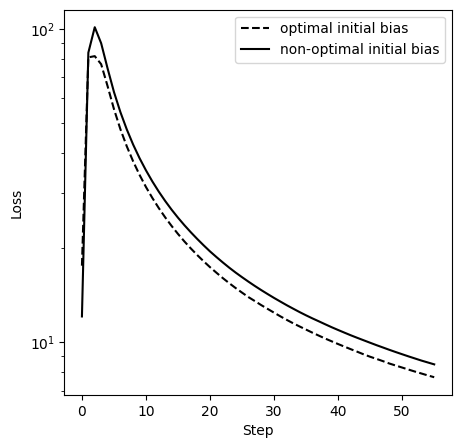

In [13]:

plt.figure(figsize=(5, 5))
plt.plot(opt_bias_callback.batch_losses, 'k--', label="optimal initial bias")
plt.plot(normal_callback.batch_losses, 'k-', label="non-optimal initial bias")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Loss")
plt.yscale('log')  # Setting y-axis to log scale
plt.savefig("opt-vs-normal-loss.svg", bbox_inches="tight", transparent=True)


small difference.

but over a large number of epochs:

In [14]:
epochs = 20
batch_size = 32

normal_callback = BatchLossCallback()
normal_history = normal_model.fit(x_train, 
                                  y_train, 
                                  batch_size=batch_size, 
                                  epochs=epochs, 
                                  callbacks=[normal_callback])

opt_bias_callback = BatchLossCallback()
opt_bias_history = opt_bias_model.fit(x_train, 
                                      y_train, 
                                      batch_size=batch_size, 
                                      epochs=epochs, 
                                      callbacks=[opt_bias_callback])

Epoch 1/20


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4258 - loss: 1.6134
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4778 - loss: 1.4998
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6745 - loss: 0.9321
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7812 - loss: 0.6419
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8432 - loss: 0.4874
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8982 - loss: 0.3098
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9109 - loss: 0.2667
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8898 - loss: 0.3249
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9485 - loss: 0.2001
Epoch 10/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9610 - loss: 0.1192
Epoch 11/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9541 - loss: 0.1481
Epoch 12/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9821 - loss: 0.0754


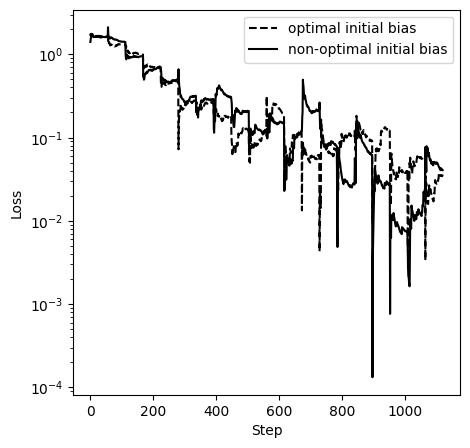

In [15]:
plt.figure(figsize=(5, 5))
plt.plot(opt_bias_callback.batch_losses, 'k--', label="optimal initial bias")
plt.plot(normal_callback.batch_losses, 'k-', label="non-optimal initial bias")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Loss")
plt.yscale('log')  # Setting y-axis to log scale
plt.savefig("opt-vs-normal-loss.svg", bbox_inches="tight", transparent=True)


they look pretty much the same